# Plant Species Classification

This tutorial is a primer on image data related machine learning. You will learn the basics of image data preprocessing & data augmentation. Then you will build classification models to classify plant species using traditional ML algorithm, CNN-based and pretrained models. A brief summary of steps in this tutorial is listed below.

### Data
- Get the data for colored RGB images of plant species from link: https://github.com/spMohanty/PlantVillage-Dataset

### Steps in this tutorial

1. Load the dataset
  - Load healthy species 
2. Eploratory data analysis
  - Plot randomly selected species
3. Initial data preprocessing
  - Resize images
  - Normalize image pixel values
4. Explore some image data preprocessing techniques
  - Change the color space
  - Gamma correct images
  - Histogram equalization technique (CLAHE)
5. Data augmentation
  - Generate & plot augmented image from a sample crop species
  - Generate augmented images in bulk
6. Generate labels
7. Shape and generate train/test data splits
8. Model training and evaluation
  - Using RandomForestClassifier
  - Plotting confusion matrix
  - Using CNNs
9. Using pretrained model - MobileNet
  - Use image generators with pretrained model
  - Model training and validation
  - Test model performance


In [1]:
# import necessary libraries

import os
import random
import time
import pickle
import itertools

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

### 1. Load image samples for healthy species

In [3]:
# select the base directory of images, we will only use RGB images
base_dir = 'PlantVillage-Dataset/raw/color/'

# list of all healthy species
list_of_healthy_dirs = []

print('List of all the healthy species...\n')

# append all the healthy species dir name to the list
for directory in os.listdir(base_dir):
    if 'healthy' in directory:
        list_of_healthy_dirs.append(directory)
        
        # check the number of healthy samples in each healthy species dir
        healthy_dir = os.path.join(base_dir, directory)
        healthy_samples = os.listdir(healthy_dir)

        print(directory + ': ' + str(len(healthy_samples)))

List of all the healthy species...

Strawberry___healthy: 456
Blueberry___healthy: 1502
Corn_(maize)___healthy: 1162
Peach___healthy: 360
Pepper,_bell___healthy: 1478
Grape___healthy: 423
Raspberry___healthy: 371
Tomato___healthy: 1591
Cherry_(including_sour)___healthy: 854
Apple___healthy: 1645
Potato___healthy: 152
Soybean___healthy: 5090


In [4]:
# define the selected list of species to be used for classification task
# for the ease of demonstration: we'll chose classes with balanced healthy samples, but you can chose any number of
# crop species you feel like

selected_species_list = ['Blueberry___healthy', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Tomato___healthy', 'Apple___healthy']

print('Selected species list: ' , selected_species_list)

Selected species list:  ['Blueberry___healthy', 'Corn_(maize)___healthy', 'Pepper,_bell___healthy', 'Tomato___healthy', 'Apple___healthy']


### 2. Explore the dataset

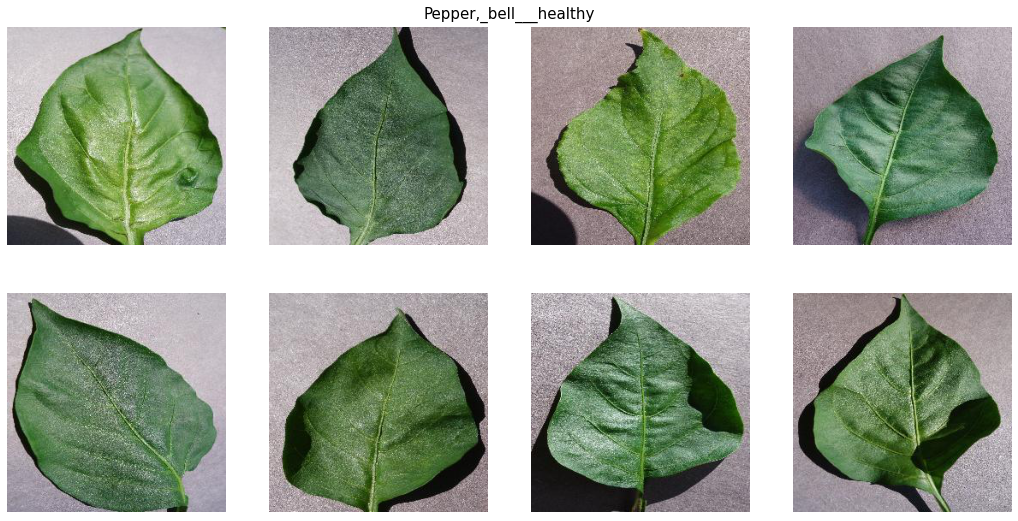

In [4]:
# Plot healthy samples for a given species
%matplotlib inline

# randomly select a species
species_dir = random.choice(selected_species_list)
species_dir_path = os.path.join(base_dir, species_dir)
species_samples = os.listdir(species_dir_path)

fig = plt.figure(figsize=(18,9))
plt.title(species_dir, fontsize=15)
plt.axis('Off')

# plot a few samples from the randomly selected species
for index, image_path in enumerate(species_samples[:8]):
    sp = fig.add_subplot(2, 4, index + 1)
    sp.axis('Off')
    img = mpimg.imread(species_dir_path + '/' + image_path)
    imgplot = plt.imshow(img)

### 3. Initial data preprocessing

In [5]:
# create a list for labels and images

image_list, label_list = [], []
default_image_size = tuple((256, 256))

# iterate through the list of dirs for selected species
for species_dir in selected_species_list:

    # get the species dir and list of images in the dir
    species_dir_path = os.path.join(base_dir, species_dir)
    species_samples = os.listdir(species_dir_path)
    print('Processing species dir: ', species_dir)

    # iterate through all images for a given species
    for index, image_path in enumerate(species_samples):
        img = mpimg.imread(species_dir_path + '/' + image_path)

        # Resize images
        img = cv2.resize(img, default_image_size)
        
        # check if all images are of fixed shape
        if img.shape != (256,256,3):
            continue

        # Normalize images to pixel values [0,1]
        img = img/255

        # append the image to the list
        image_list.append(img)

        # get the appropriate label name using the species dir
        label = species_dir.split('_')[0]

        # remove the punctuation char from 'Pepper' label
        if 'Pepper' in label:
            label = 'Pepper'

        # add label to the label list
        label_list.append(label)

Processing species dir:  Blueberry___healthy
Processing species dir:  Corn_(maize)___healthy
Processing species dir:  Pepper,_bell___healthy
Processing species dir:  Tomato___healthy
Processing species dir:  Apple___healthy


In [6]:
# check the size of image & label list

print('Size of image list: %s' %len(image_list))
print('Size of labels: %s' %len(label_list))

Size of image list: 7377
Size of labels: 7377


### 4. Explore some more image data preprocessing techniques

#### Changing Color Spaces

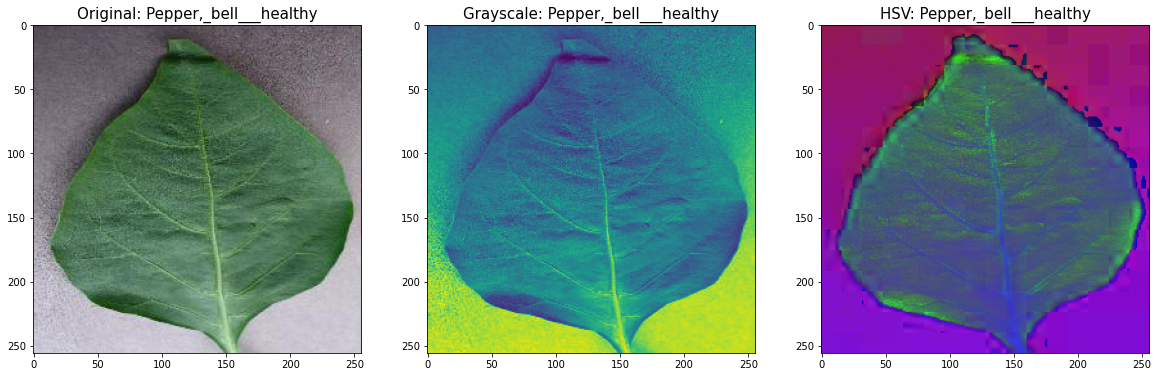

In [7]:
# randomly select an image

species_dir = random.choice(selected_species_list)
species_dir_path = os.path.join(base_dir, species_dir)
species_samples = os.listdir(species_dir_path)
sample_species = random.choice(species_samples)

test_image = mpimg.imread(species_dir_path + '/' + sample_species)

# define subplots
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)

# plot original image
plt.imshow(test_image)
plt.title('Original: ' + species_dir, fontsize=15)

#converting image to Gray scale & plot
gray_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
fig.add_subplot(1, 3, 2)
plt.imshow(gray_image)
plt.title('Grayscale: ' + species_dir, fontsize=15)

#converting image to HSV format & plot
hsv_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2HSV)
fig.add_subplot(1, 3, 3)
plt.imshow(hsv_image)
plt.title('HSV: ' + species_dir, fontsize=15)

plt.show()

#### Gamma Correction

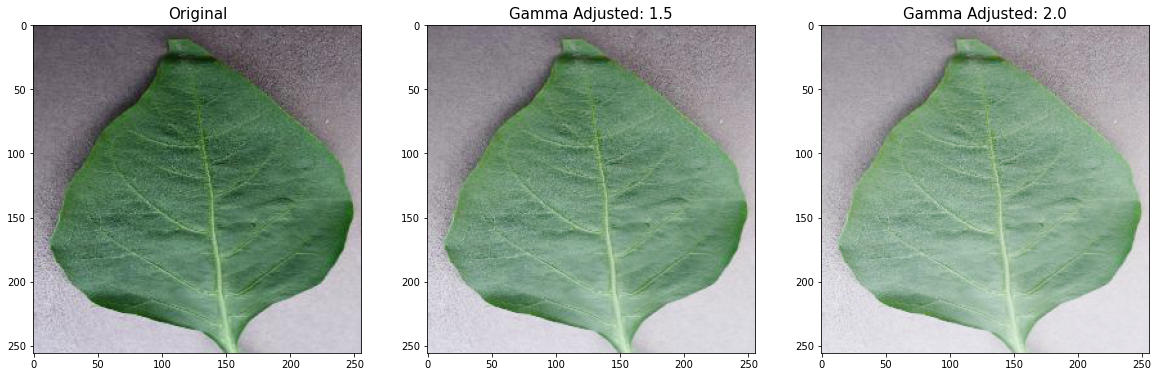

In [8]:
# define a method for Gamma correction

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    return cv2.LUT(image, table)

# define subplots
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Original', fontsize=15)

# define gamma value
gamma_1 = 1.5
adjusted_gamma_1 = adjust_gamma(test_image, gamma=gamma_1)

# define another gamma correction value
gamma_2 = 2.0
adjusted_gamma_2 = adjust_gamma(test_image, gamma=gamma_2)

# plot gamma correction for first gamma
fig.add_subplot(1, 3, 2)
plt.imshow(adjusted_gamma_1)
plt.title('Gamma Adjusted: %s' %gamma_1, fontsize=15)

# plot gamma correction for second gamma
fig.add_subplot(1, 3, 3)
plt.imshow(adjusted_gamma_2)
plt.title('Gamma Adjusted: %s' %gamma_2, fontsize=15)

plt.show()

#### Histogram equalization: CLAHE (contrast limited adaptive histogram equalization)

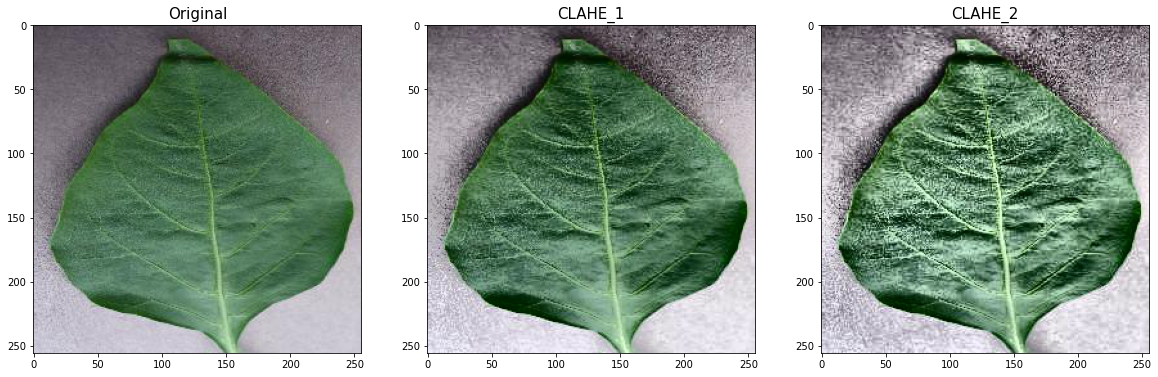

In [9]:
# change the RGB to YUV (luminance) color space and then apply equalization

img_yuv = cv2.cvtColor(test_image, cv2.COLOR_RGB2YUV)

# apply equalization of grid 2x2
clahe_1 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))
img_yuv[:,:,0] = clahe_1.apply(img_yuv[:,:,0])
clache_img_1 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# apply equalization of grid 8x8
clahe_2 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_yuv[:,:,0] = clahe_2.apply(img_yuv[:,:,0])
clache_img_2 = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

# plot the original image
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(test_image)
plt.title('Original', fontsize=15)

# plot the histogram equalized image
fig.add_subplot(1, 3, 2)
plt.imshow(clache_img_1)
plt.title('CLAHE_1', fontsize=15)

# plot the histogram equalized image
fig.add_subplot(1, 3, 3)
plt.imshow(clache_img_2)
plt.title('CLAHE_2', fontsize=15)

plt.show()

### 5. Data Augmentation

In [10]:
# create a image generator object using the keras ImageDataGenerator and assign values to the parameters,
# based on which the images will be generated

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

#### Generate and plot data augmentation on a sample crop image

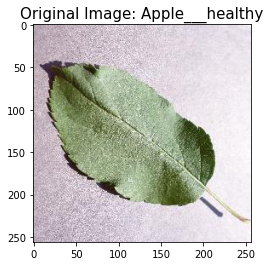

In [11]:
# randomly select an image

species_dir = random.choice(selected_species_list)
species_dir_path = os.path.join(base_dir, species_dir)
species_samples = os.listdir(species_dir_path)
sample_species = random.choice(species_samples)

# check if the 'data_aug_dir' folder exists, if not then create. 
# data_aug_dir: this dir will have the generated augmented images for a randomly selected image above

aug_img_dir = 'data_aug_dir'
if not os.path.exists(aug_img_dir):
    os.makedirs(aug_img_dir)

# read the image and convert it to array
aug_img = mpimg.imread(species_dir_path + '/' + sample_species)
aug_imgplot = plt.imshow(aug_img)
plt.title('Original Image: ' + species_dir, fontsize=15)
x = np.array(aug_img)  # this is a numpy array with shape (256, 256, 3)
x = x.reshape((1,) + x.shape)  # this is a numpy array with shape (1, 256, 256, 3)

# the flow() command below generates batches of randomly transformed images
# for now, we're generating 'max_num_aug_images' number of augmented images

max_num_aug_images = 8
iterator = 0
for batch in datagen.flow(x, batch_size = 1, save_to_dir=aug_img_dir, save_prefix=species_dir, save_format='JPG'):
    iterator += 1
    if iterator >= max_num_aug_images:
        break  # otherwise the generator would loop indefinitely

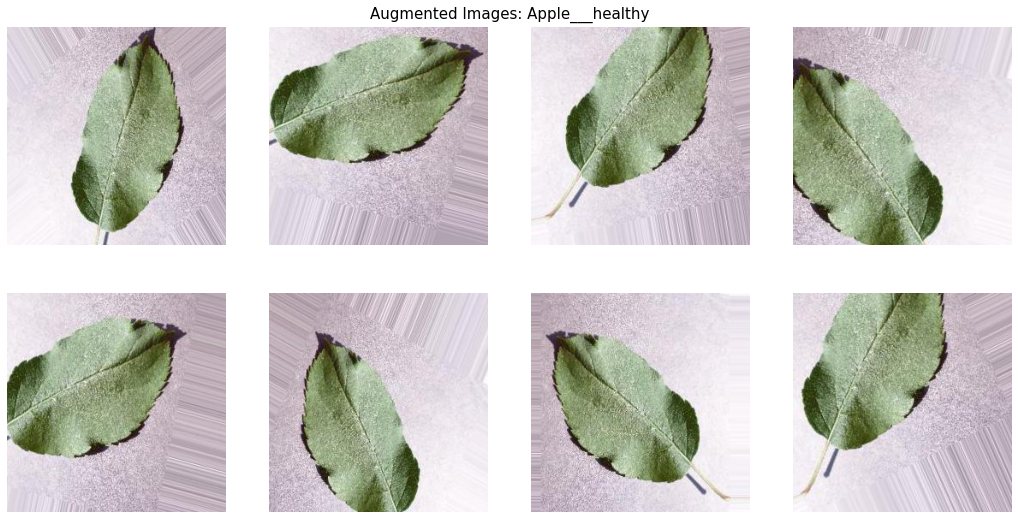

In [12]:
# plot the generated augmented images from the dir: data_aug_dir

fig = plt.figure(figsize=(18,9))
plt.title('Augmented Images: ' + species_dir, fontsize=15)
plt.axis('Off')

# list all files in data_aug_dir folder
aug_images = os.listdir('data_aug_dir')

# plot all the augmneted images in 'data_aug_dir' folder
set_index = 0
for index, image_path in enumerate(aug_images):
    if 'JPG' not in image_path:
        set_index+=1
        continue
    sp = fig.add_subplot(2, 4, (index - set_index) + 1)
    sp.axis('Off')
    img = mpimg.imread('data_aug_dir' + '/' + image_path)
    imgplot = plt.imshow(img)

#### Generate augmented images for crop species in bulk

In [13]:
# select the base aug directory to store the bulk generated images
aug_base_dir = 'bulk_aug_images/'

# predefine number of images to generate for each image
num_aug_images = 2

# generated a predefined set of images for each image belonging to all the selected healthy species
for healthy_species in selected_species_list:
    healthy_dir_path = os.path.join(base_dir, healthy_species)
    species_samples = os.listdir(healthy_dir_path)
    
    # create a healthy aug dir sub-folder
    aug_healthy_dir = aug_base_dir + '/' + healthy_species
    
    # check if the aug healthy folder exists, if not, create
    if not os.path.exists(aug_healthy_dir):
        os.makedirs(aug_healthy_dir)
    
    for image in species_samples:
        
        # read image and reshape
        aug_img = mpimg.imread(healthy_dir_path + '/' + image)
        x = np.array(aug_img)  # this is a numpy array with shape (256, 256, 3) 
        x = x.reshape((1,) + x.shape)  # this is a numpy array with shape (1, 256, 256, 3)
        
        # create the iterator and generate new images
        try:
            iterator = datagen.flow(x, batch_size = 1, save_to_dir=aug_healthy_dir, save_prefix=healthy_species, 
                                    save_format='JPG')

            # loop through the iterator for predefined number of times to generate images
            for i in range(num_aug_images):
                iterator.next()
                
        except:
            print('Some issue with the image, skipping it..')
            continue

Some issue with the image, skipping it..


#### Review data preprocessing

- Until this point, we explored a bunch of image data preprocessing techniques
- Going forward, we'll work towards building a classification model for healthy plant species just using the initial data preprocessing techniques which we looked at in section 3.

### 6. Generate labels

In [14]:
# one-hot encode labels for the selected species

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

# store the one-hot encoded labels for future reference
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print('Number of labels/classes: %s' %n_classes)

Number of labels/classes: 5


In [15]:
print('Labels/species:', label_binarizer.classes_)

Labels/species: ['Apple' 'Blueberry' 'Corn' 'Pepper' 'Tomato']


### 7. Shape data and generate train/test splits

In [16]:
# convert image list to a numpy array

np_image_list = np.array(image_list)

In [17]:
print('Data Shape:', np_image_list.shape)

Data Shape: (7377, 256, 256, 3)


In [18]:
print('Label Shape:', image_labels.shape)

Label Shape: (7377, 5)


In [19]:
# generate train/test split

X_train, X_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [20]:
print('Train X:', X_train.shape)
print('Train y:', y_train.shape)

Train X: (5901, 256, 256, 3)
Train y: (5901, 5)


In [21]:
print('Test X:', X_test.shape)
print('Test y:', y_test.shape)

Test X: (1476, 256, 256, 3)
Test y: (1476, 5)


One-hot encoded label [0 0 0 0 1] belongs to the species: Tomato


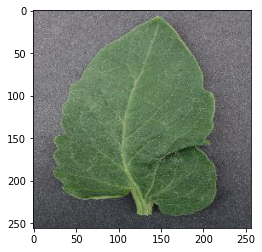

In [22]:
# plot a training sample along with the corresponding one-hot encoded label

print('One-hot encoded label', y_train[0], 'belongs to the species:', label_binarizer.inverse_transform(y_train)[0])

plt.imshow(X_train[0])
plt.show()

### 8. Model training & evaluation

#### Using RandomForest Classifier

In [23]:
# import the randomforest classifier, test using default parameters

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [24]:
# we need to reshape our data, as the algorithms expects a 1-d array, hence flatten the pixel values

X_rf_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_rf_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

print('Train reshape:', X_rf_train.shape)
print('Test reshape:', X_rf_test.shape)

Train reshape: (5901, 196608)
Test reshape: (1476, 196608)


In [25]:
# train the model

rf_start_time = time.time()

clf.fit(X_rf_train, y_train)

print('Execution time: %s mins' %((time.time() - rf_start_time)/60))

Execution time: 3.547434997558594 mins


In [26]:
# predict using the test data

from sklearn.metrics import accuracy_score

rf_test_pred = clf.predict(X_rf_test)

print('Test Accuracy:', accuracy_score(y_test, rf_test_pred))

Test Accuracy: 0.739159891598916


#### Plot confusion matrix to analyze correct vs. miss-classification

In [27]:
# transform predictions from one-hot encoded label to actual species labels

predicted_test_species = label_binarizer.inverse_transform(rf_test_pred)

In [28]:
predicted_test_species.shape

(1476,)

In [29]:
# transform the test labels from one-hot encoded label to actual species labels

actual_test_species = label_binarizer.inverse_transform(y_test)

In [30]:
actual_test_species.shape

(1476,)

In [31]:
# calculate the confusion matrix for multi-class

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(actual_test_species, predicted_test_species)

In [32]:
# print the confusion matrix

cnf_matrix

array([[324,   7,   0,   2,   0],
       [ 83, 226,   0,   4,   4],
       [ 17,   1, 222,   0,   1],
       [ 69,   1,   0, 219,   1],
       [ 99,   0,   0,   0, 196]])

In [33]:
# get the actual species label/class names

class_names = label_binarizer.classes_

In [34]:
class_names

array(['Apple', 'Blueberry', 'Corn', 'Pepper', 'Tomato'], dtype='<U9')

In [35]:
# method to plot confusion matrix

def confusion_matrix_plot(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    sns.set_style('dark')
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()

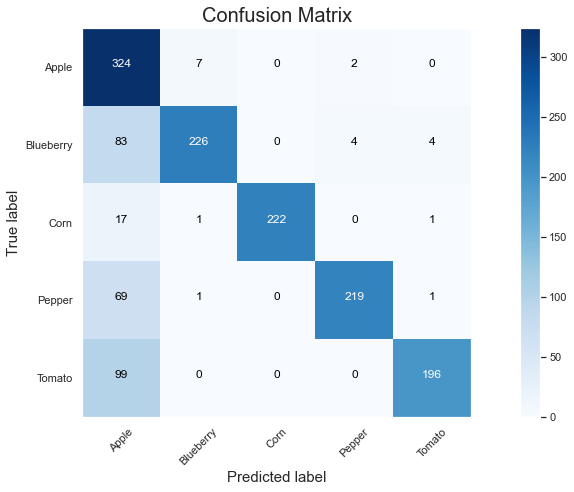

In [38]:
# plotting the confusion matrix

confusion_matrix_plot(cnf_matrix, classes=list(class_names), title='Confusion Matrix')

#### Using CNNs

In [43]:
# define CNN model architecture

model = Sequential()
inputShape = (256, 256, 3)

model.add(Conv2D(32, (3, 3), input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

In [44]:
# print model summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 82, 82, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)            

In [45]:
# compile your model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
# train and store the result in history object

start_cnn_time = time.time()

hist = model.fit(X_train, y_train, batch_size=256, epochs=10, validation_split=0.2, verbose=2)

print('\nExecution time: %s mins' %((time.time() - start_cnn_time)/60))

Epoch 1/10
19/19 - 104s - loss: 2.3917 - accuracy: 0.4659 - val_loss: 0.5610 - val_accuracy: 0.8036
Epoch 2/10
19/19 - 93s - loss: 0.3151 - accuracy: 0.8951 - val_loss: 0.1951 - val_accuracy: 0.9289
Epoch 3/10
19/19 - 74s - loss: 0.1485 - accuracy: 0.9498 - val_loss: 0.1295 - val_accuracy: 0.9619
Epoch 4/10
19/19 - 77s - loss: 0.0866 - accuracy: 0.9722 - val_loss: 0.0937 - val_accuracy: 0.9678
Epoch 5/10
19/19 - 77s - loss: 0.0526 - accuracy: 0.9852 - val_loss: 0.0929 - val_accuracy: 0.9687
Epoch 6/10
19/19 - 72s - loss: 0.0451 - accuracy: 0.9879 - val_loss: 0.1090 - val_accuracy: 0.9610
Epoch 7/10
19/19 - 69s - loss: 0.0400 - accuracy: 0.9894 - val_loss: 0.0845 - val_accuracy: 0.9746
Epoch 8/10
19/19 - 76s - loss: 0.0191 - accuracy: 0.9951 - val_loss: 0.0808 - val_accuracy: 0.9746
Epoch 9/10
19/19 - 74s - loss: 0.0116 - accuracy: 0.9981 - val_loss: 0.0673 - val_accuracy: 0.9780
Epoch 10/10
19/19 - 74s - loss: 0.0077 - accuracy: 0.9987 - val_loss: 0.0688 - val_accuracy: 0.9805

Executi

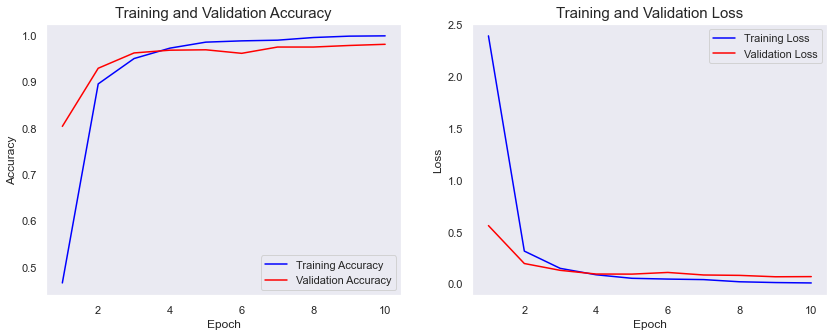

In [47]:
# plot training loss and accuracy

# get accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# get loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(14,5))

# Plot train and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.legend(loc='best')

# plot train and validation loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss', color='blue')
plt.plot(epochs, val_loss, 'r', label='Validation Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss', fontsize=15)
plt.legend(loc='best')

plt.show()

In [48]:
# evaluate model on test data

scores = model.evaluate(X_test, y_test)

print('Test Accuracy: ', scores[1])

47/47 [==============================] - 8s 160ms/step - loss: 0.0633 - accuracy: 0.9804
Test Accuracy:  0.9803522825241089


### 9. Using pretrained model: MobileNet

In [49]:
# import the MobileNet pre-trained model from keras

from keras.applications import MobileNet
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# initialize which weights to use and cut-off the fully connected top layer
pretrained_model = MobileNet(weights='imagenet',include_top=False)

pretrained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

In [50]:
# we don't need to train layers in our pretrained model, so set it to false

for layer in pretrained_model.layers:
    layer.trainable=False

In [51]:
# define the output from pre-trained model and add layers
X = pretrained_model.output
X = GlobalAveragePooling2D()(X)

# adding dense layers for the pretrained model to learn weights on our data
X = Dense(1024, activation='relu')(X)
X = Dense(1024, activation='relu')(X)
x = Dense(512, activation='relu')(X)

# last layer should be softmax with number of classes
pred = Dense(n_classes, activation='softmax')(X)

In [52]:
# define the new model

new_model = Model(inputs = pretrained_model.input, outputs=pred)

new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

In [53]:
# compile model

new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Using image generators with pretrained model

Directory Structure: We need the following directory structure for train, validate and test data, in order to use the 'image_dataset_from_directory' fucntion in keras


- train/
  - ...class_a/
    - ......a_image_1.jpg
    - ......a_image_2.jpg
  - ...class_b/
    - ......b_image_1.jpg
    - ......b_image_2.jpg
    
    
- valid/
  - ...class_a/
    - ......a_image_1.jpg
    - ......a_image_2.jpg
  - ...class_b/
    - ......b_image_1.jpg
    - ......b_image_2.jpg
    
    
- test/
  - ...test_images/
    - ......a_image_1.jpg
    - ......a_image_2.jpg
    - ......b_image_1.jpg
    - ......b_image_2.jpg

In [54]:
# define image generators

from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# we need to preprocess input based on how MobileNet was trained
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [55]:
# define the train generator, with a fixed batch size

train_generator = train_datagen.flow_from_directory('./Healthy_Species/train/',
                                                 target_size=(256,256),
                                                 color_mode='rgb',
                                                 batch_size=256,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 seed=42)

Found 6378 images belonging to 5 classes.


In [56]:
# define the validate generator, ideally choose batch size which divides the total samples

valid_generator = valid_datagen.flow_from_directory(directory='./Healthy_Species/valid/',
                                                    target_size=(256, 256),
                                                    color_mode='rgb',
                                                    batch_size=25,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    seed=42)

Found 500 images belonging to 5 classes.


In [57]:
# define the test generator, ideally choose batch size which divides the total samples
# shuffle as false for test data, class_mode to None to return only the images

test_generator = test_datagen.flow_from_directory(directory='./Healthy_Species/test/',
                                                    target_size=(256, 256),
                                                    color_mode='rgb',
                                                    batch_size=25,
                                                    class_mode=None,
                                                    shuffle=False,
                                                    seed=42)

Found 500 images belonging to 1 classes.


#### Model training and validation

In [58]:
# define the step size for each epoch

step_size_train = train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

# train model

start_pretrained_time = time.time()

history = new_model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = step_size_train,
                                  validation_data = valid_generator,
                                  validation_steps = step_size_valid,
                                  epochs=5)

print('\nExecution time: %s mins' %((time.time() - start_pretrained_time)/60))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
24/24 [==============================] - 94s 4s/step - loss: 0.4572 - accuracy: 0.8567 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 2/5
24/24 [==============================] - 91s 4s/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 3/5
24/24 [==============================] - 90s 4s/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/5
24/24 [==============================] - 105s 4s/step - loss: 9.0245e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/5
24/24 [==============================] - 108s 5s/step - loss: 4.1800e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000

Execution time: 8.53391649723053 mins


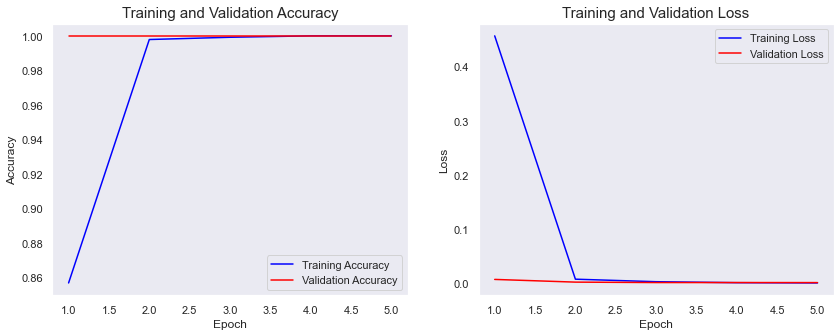

In [59]:
# plot training and validation accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(14,5))

#Train and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy', color='red')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.legend(loc='best')

#Train and validation loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss', color='blue')
plt.plot(epochs, val_loss, 'r', label='Validation Loss', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss', fontsize=15)
plt.legend(loc='best')

plt.show()

In [60]:
# validate the model

scores = new_model.evaluate_generator(generator = valid_generator, steps = step_size_valid)

print('Model accuracy', scores[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Model accuracy 1.0


#### Test model performance

In [61]:
step_size_test = test_generator.n//test_generator.batch_size

# need to reset test generator to get outputs in order
test_generator.reset()

# make predictions
pretrained_test_predictions = new_model.predict_generator(test_generator, steps = step_size_test, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 6s 312ms/step


In [62]:
# get the predicted labels

predicted_class_indices = np.argmax(pretrained_test_predictions, axis=1)

In [63]:
# map the predicted labels with the filenames to find out the prediction for each image

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

predicted_labels = [labels[k] for k in predicted_class_indices]

In [64]:
# make sure the image filenames have label string in them

filenames = test_generator.filenames

results = pd.DataFrame({'Filename':filenames,'Predictions':predicted_labels})

# setting the column width to max
pd.set_option('max_colwidth', None)
results.head()

Filename  \
0  test_images/002f87b7-e1a5-49e5-a422-bb423630ded5___Pepper_HL 8068.JPG   
1   test_images/02cd3257-a42f-4fbc-8056-a41d5aabfbc3___Apple_HL 8029.JPG   
2   test_images/02d0257a-d21a-43a4-9348-472043df801e___Apple_HL 6065.JPG   
3  test_images/02d94768-da6d-4c1a-b8b3-fa2e5a2fcd4d___RS_Tomato 0449.JPG   
4   test_images/02fe229e-2b2e-4e1e-b56f-3af97996bee6___Apple_HL 8134.JPG   

              Predictions  
0  Pepper,_bell___healthy  
1         Apple___healthy  
2         Apple___healthy  
3        Tomato___healthy  
4         Apple___healthy

In [65]:
# calculate the accuracy, need to compare predicted labels with actual labels
# actual labels can be derived from filenames as shown below

apple_match_count = 0
blueberry_match_count = 0
corn_match_count = 0
pepper_match_count = 0
tomato_match_count = 0

for index, row in results.iterrows():
    if ('apple' in row['Filename'].lower()) & ('apple' in row['Predictions'].lower()):
        apple_match_count+=1
    elif ('blueberry' in row['Filename'].lower()) & ('blueberry' in row['Predictions'].lower()):
        blueberry_match_count+=1
    elif ('corn' in row['Filename'].lower()) & ('corn' in row['Predictions'].lower()):
        corn_match_count+=1
    elif ('pepper' in row['Filename'].lower()) & ('pepper' in row['Predictions'].lower()):
        pepper_match_count+=1
    elif ('tomato' in row['Filename'].lower()) & ('tomato' in row['Predictions'].lower()):
        tomato_match_count+=1
    else:
        continue

In [66]:
print('Apple Matches: %s' %apple_match_count)
print('Blueberry Matches: %s' %blueberry_match_count)
print('Corn Matches: %s' %corn_match_count)
print('Pepper Matches: %s' %pepper_match_count)
print('Tomato Matches: %s' %tomato_match_count)

Apple Matches: 100
Blueberry Matches: 100
Corn Matches: 100
Pepper Matches: 100
Tomato Matches: 100


In [67]:
print('Accuracy: %f' %(np.mean([apple_match_count/100,blueberry_match_count/100, corn_match_count/100,
                               pepper_match_count/100, tomato_match_count/100])))

Accuracy: 1.000000
